In [1]:
#Import libraries as needed
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, first, last, lag, lead, when
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

conf = SparkConf().setAppName('yuck').setMaster("local[*]").set("spark.driver.memory", "4g")
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

In [3]:
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType

# Define the schema for the CSV files
schema = StructType([
    StructField("unix_time", TimestampType(), True),
    StructField("row_num", IntegerType(), False),
    StructField("AQI_Index", IntegerType(), True),
    StructField("AQI_Category", StringType(), True),
    StructField("AQI_GenPop_Category", StringType(), True),
    StructField("AQI_GenPop_Index", IntegerType(), True),
    StructField("BEN", DoubleType(), True),
    StructField("CO", DoubleType(), True),
    StructField("EBE", DoubleType(), True),
    StructField("MXY", DoubleType(), True),
    StructField("NMHC", DoubleType(), True),
    StructField("NO_2", DoubleType(), True),
    StructField("NOx", DoubleType(), True),
    StructField("OXY", DoubleType(), True),
    StructField("O_3", DoubleType(), True),
    StructField("PM10", DoubleType(), True),
    StructField("PM25", DoubleType(), True),
    StructField("PXY", DoubleType(), False),
    StructField("SO_2", DoubleType(), True),
    StructField("TCH", DoubleType(), True),
    StructField("TOL", DoubleType(), True)])


In [4]:
# insert csv files to spark_df dataframe
data_path = 'C:\\Users\\eleni\\Documents\\Diplw\\Jupyter-Notebooks\\diplw\\csvs_per_year\\clean_wo_norm.csv'
spark_df = spark.read.csv(data_path, header=True, schema=schema)

In [5]:
spark_df.printSchema()

root
 |-- unix_time: timestamp (nullable = true)
 |-- row_num: integer (nullable = true)
 |-- AQI_Index: integer (nullable = true)
 |-- AQI_Category: string (nullable = true)
 |-- AQI_GenPop_Category: string (nullable = true)
 |-- AQI_GenPop_Index: integer (nullable = true)
 |-- BEN: double (nullable = true)
 |-- CO: double (nullable = true)
 |-- EBE: double (nullable = true)
 |-- MXY: double (nullable = true)
 |-- NMHC: double (nullable = true)
 |-- NO_2: double (nullable = true)
 |-- NOx: double (nullable = true)
 |-- OXY: double (nullable = true)
 |-- O_3: double (nullable = true)
 |-- PM10: double (nullable = true)
 |-- PM25: double (nullable = true)
 |-- PXY: double (nullable = true)
 |-- SO_2: double (nullable = true)
 |-- TCH: double (nullable = true)
 |-- TOL: double (nullable = true)



In [6]:
#Check if df ok
from pyspark.sql.functions import col, sum
from pyspark.sql.functions import isnan, when, count

null_counts = spark_df.agg(*[sum(col(c).isNull().cast("int")).alias(c) for c in spark_df.columns])

# Print out the null counts for each column
null_counts.show()

#END FILL IN MISSING VALUES

+---------+-------+---------+------------+-------------------+----------------+---+---+---+---+----+----+---+---+---+----+----+---+----+---+---+
|unix_time|row_num|AQI_Index|AQI_Category|AQI_GenPop_Category|AQI_GenPop_Index|BEN| CO|EBE|MXY|NMHC|NO_2|NOx|OXY|O_3|PM10|PM25|PXY|SO_2|TCH|TOL|
+---------+-------+---------+------------+-------------------+----------------+---+---+---+---+----+----+---+---+---+----+----+---+----+---+---+
|        0|      0|        0|           0|                  0|               0|  0|  0|  0|  0|   0|   0|  0|  0|  0|   0|   0|  0|   0|  0|  0|
+---------+-------+---------+------------+-------------------+----------------+---+---+---+---+----+----+---+---+---+----+----+---+----+---+---+



In [ ]:
#Z-SCORE NORM STARTS HERE

In [7]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import expr
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import array

# Get the columns to normalize
pollutants = spark_df.columns[6:]

# Create a VectorAssembler to combine the columns to be normalized
assembler = VectorAssembler(inputCols=pollutants, outputCol="features")

# Transform the Spark DataFrame using the VectorAssembler
assembled_df = assembler.transform(spark_df)

# Create a StandardScaler object
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=True)

# Compute summary statistics and generate a StandardScalerModel
scalerModel = scaler.fit(assembled_df)

# Normalize the data using the StandardScalerModel
scaled_df = scalerModel.transform(assembled_df)


In [8]:
# Convert the 'scaledFeatures' struct column into an array column
array_df = scaled_df.select("row_num", vector_to_array('scaledFeatures').alias('scaled_array'))

# Select individual elements of the array and create separate columns for each pollutant
for i, col in enumerate(pollutants):
    array_df = array_df.withColumn(col, array_df['scaled_array'][i])

# Drop the 'scaled_array' column
array_df = array_df.drop('scaled_array')

# Join the normalized pollutant columns with the original DataFrame
norm_df = spark_df.select(*spark_df.columns[:6]).join(array_df, on="row_num", how="inner")

In [ ]:
#CHECKING IF NORM SUCCESSFULL

In [9]:
norm_df.printSchema()

root
 |-- row_num: integer (nullable = true)
 |-- unix_time: timestamp (nullable = true)
 |-- AQI_Index: integer (nullable = true)
 |-- AQI_Category: string (nullable = true)
 |-- AQI_GenPop_Category: string (nullable = true)
 |-- AQI_GenPop_Index: integer (nullable = true)
 |-- BEN: double (nullable = true)
 |-- CO: double (nullable = true)
 |-- EBE: double (nullable = true)
 |-- MXY: double (nullable = true)
 |-- NMHC: double (nullable = true)
 |-- NO_2: double (nullable = true)
 |-- NOx: double (nullable = true)
 |-- OXY: double (nullable = true)
 |-- O_3: double (nullable = true)
 |-- PM10: double (nullable = true)
 |-- PM25: double (nullable = true)
 |-- PXY: double (nullable = true)
 |-- SO_2: double (nullable = true)
 |-- TCH: double (nullable = true)
 |-- TOL: double (nullable = true)



In [8]:
norm_df.filter("row_num in (1, 2, 3, 4, 5)").show(5)

+-------+-------------------+---------+------------+-------------------+----------------+------------------+------------------+------------------+------------------+-------------------+-------------------+--------------------+--------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+------------------+
|row_num|          unix_time|AQI_Index|AQI_Category|AQI_GenPop_Category|AQI_GenPop_Index|               BEN|                CO|               EBE|               MXY|               NMHC|               NO_2|                 NOx|                 OXY|                O_3|               PM10|               PM25|                 PXY|               SO_2|                TCH|               TOL|
+-------+-------------------+---------+------------+-------------------+----------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------

In [10]:
from pyspark.sql.functions import mean

# assume 'df' is your Spark DataFrame
means = norm_df.agg(*[mean(c).alias(c) for c in norm_df.columns[6:]])
means.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 BEN|                  CO|                 EBE|                 MXY|                NMHC|                NO_2|                 NOx|                 OXY|                 O_3|                PM10|                PM25|                 PXY|                SO_2|                 TCH|                 TOL|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|3.550788161542838...|2.095734625153725...|-6.961

In [ ]:
#END Z-Score normalization

In [ ]:
from pyspark.sql.functions import col, sum
from pyspark.sql.functions import isnan, when, count

null_counts = norm_df.agg(*[sum(col(c).isNull().cast("int")).alias(c) for c in norm_df.columns])

# Print out the null counts for each column
null_counts.show()


In [ ]:
#END Z-SCORE NORM, GRAPHS N' STUFF HERE

In [12]:
#sample spark_df 
sampled_data = norm_df.select('AQI_Index','AQI_Category','AQI_GenPop_Category','AQI_GenPop_Index','BEN', 'CO','EBE','MXY','NMHC','NO_2','NOx','OXY','O_3','PM10','PM25','PXY','SO_2','TCH','TOL').sample(False, 0.058) #40% of the data
pandas_df = sampled_data.toPandas()

In [13]:
print(pandas_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221139 entries, 0 to 221138
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   AQI_Index            221139 non-null  int32  
 1   AQI_Category         221139 non-null  object 
 2   AQI_GenPop_Category  221139 non-null  object 
 3   AQI_GenPop_Index     221139 non-null  int32  
 4   BEN                  221139 non-null  float64
 5   CO                   221139 non-null  float64
 6   EBE                  221139 non-null  float64
 7   MXY                  221139 non-null  float64
 8   NMHC                 221139 non-null  float64
 9   NO_2                 221139 non-null  float64
 10  NOx                  221139 non-null  float64
 11  OXY                  221139 non-null  float64
 12  O_3                  221139 non-null  float64
 13  PM10                 221139 non-null  float64
 14  PM25                 221139 non-null  float64
 15  PXY              

In [24]:
#sample spark_df to visualize data
sampled_data = norm_df.select('NO_2','O_3','SO_2','PM10','PM25').sample(False, 0.4) #40% of the data
pandas_df = sampled_data.toPandas()

In [15]:
pollutants=pandas_df.columns[4:]

In [16]:
print(pollutants)

Index(['BEN', 'CO', 'EBE', 'MXY', 'NMHC', 'NO_2', 'NOx', 'OXY', 'O_3', 'PM10',
       'PM25', 'PXY', 'SO_2', 'TCH', 'TOL'],
      dtype='object')


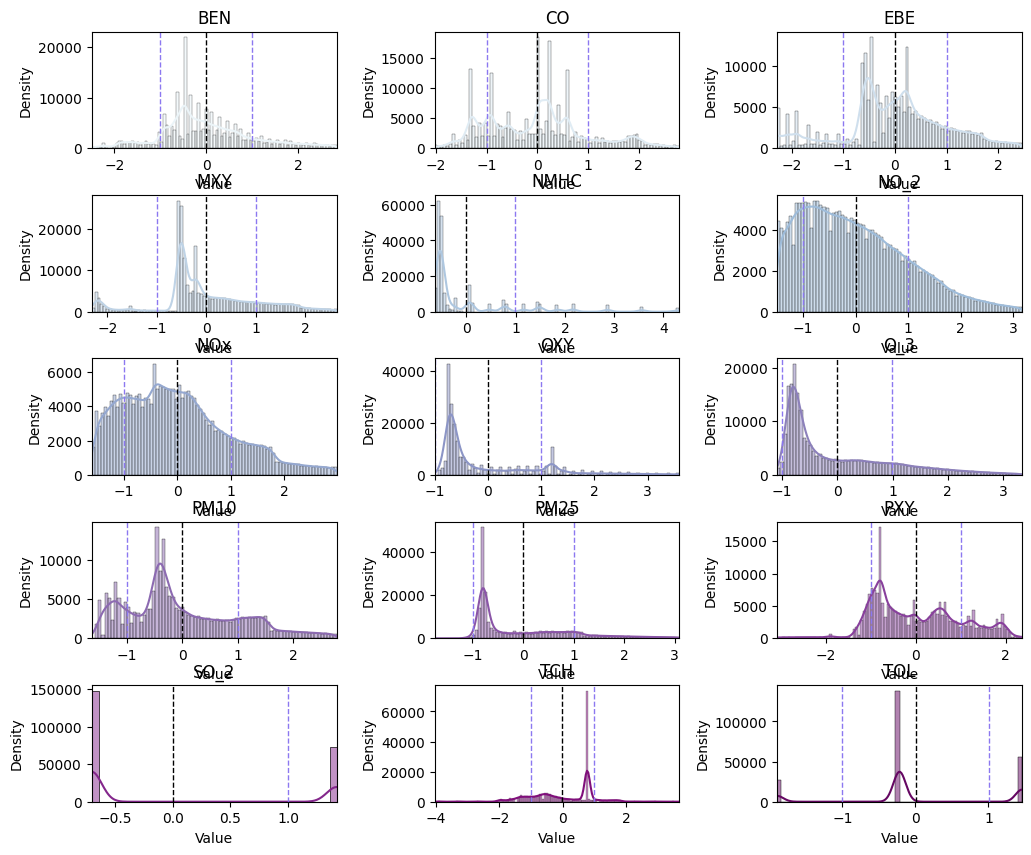

In [17]:
pandas_df = pandas_df.reset_index(drop=True)

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(12, 10))

# Plot a histogram for each column
for i, pollutant in enumerate(pollutants):
    # Get the data for the column
    data = pandas_df[pollutant].dropna()
    
    # Determine the subplot location based on the column index
    row = i // 3
    col = i % 3
    # get the range of values in the column, ignoring NaN and Inf
    x_min = np.nanmin(pandas_df[pollutant][np.isfinite(pandas_df[pollutant])])
    x_max = np.nanmax(pandas_df[pollutant][np.isfinite(pandas_df[pollutant])])
    
    # calculate number of bins using IQR rule
    n = len(pandas_df[pollutant])
    std = np.std(pandas_df[pollutant])
    k = 3.5 * std / (n**(1/3))
    num_bins = int(np.ceil((x_max - x_min) / k)) if k != 0 else 1
    # Plot the histogram with kde
    sns.histplot(data, kde=True, bins=num_bins, color=sns.color_palette("BuPu", 15)[i], ax=axs[row, col])
    
    # Add a vertical line for the mean
    mean = data.mean()
    axs[row, col].axvline(mean, color='k', linestyle='dashed', linewidth=1)
    
    # Add a vertical line for the standard deviation
    std = data.std()
    axs[row, col].axvline(mean+std, color='#8C78F0', linestyle='dashed', linewidth=1)
    axs[row, col].axvline(mean-std, color='#8C78F0', linestyle='dashed', linewidth=1)
    
    # Set the title and axis labels
    axs[row, col].set_title(pollutant)
    axs[row, col].set_xlabel('Value')
    axs[row, col].set_ylabel('Density')
    axs[row, col].set_xlim([data.min(), data.max()])  # set x-axis range

# Adjust the spacing between subplots
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Show the plot
plt.show()

In [20]:
# Extract the AQI_Categories column from spark_df
pdf = norm_df.select('AQI_GenPop_Category').toPandas()

In [ ]:
print(category_percentage)

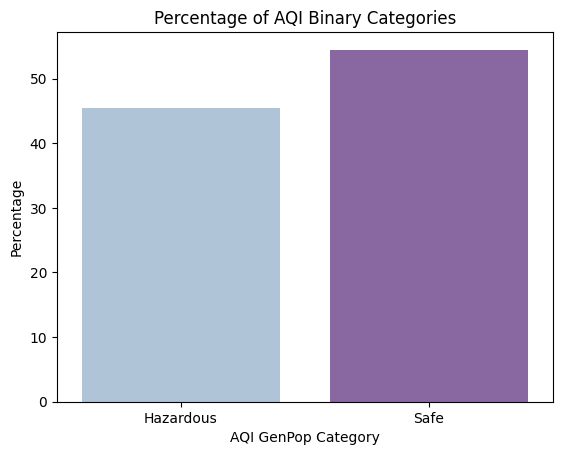

In [14]:
# Get the count of each category and calculate the percentage
category_count = pandas_df.groupby('AQI_GenPop_Category').size()
category_percentage = category_count / category_count.sum() * 100


# Create the bar plot
ax = sns.barplot(x=category_percentage.index, y=category_percentage.values, palette="BuPu")

# Set the axis labels and title
ax.set(xlabel='AQI GenPop Category', ylabel='Percentage', title='Percentage of AQI Binary Categories')

# Show the plot
plt.show()

In [11]:
norm_df.write.format('csv').option('header', True ).mode('overwrite').save('C:/Users/eleni/Documents/Diplw/Jupyter-Notebooks/diplw/csvs_per_year/clean_data_norm.csv')

In [18]:
# Save the DataFrame to a CSV file in the current working directory
pandas_df.to_csv('C:\\Users\\eleni\\Documents\\Diplw\\Jupyter-Notebooks\\diplw\\balanced_sample.csv', index=False)